# Upload files in Google Colab
If you are running this Jupyter Notebook on Google Colab, run this cell to upload the data files (train_inputs.csv, train_targets.csv, test_inputs.csv, test_targets.csv) in the colab virtual machine.  You will be prompted to select files that you would like to upload. 

If you are running this Jupyter Notebook on your computer, you do not need to run this cell.

In [1]:
from google.colab import files
uploaded = files.upload()
%ls

Saving test_inputs.csv to test_inputs.csv
Saving test_labels.csv to test_labels.csv
Saving train_inputs.csv to train_inputs.csv
Saving train_labels.csv to train_labels.csv
sample_data/     test_labels.csv   train_labels.csv
test_inputs.csv  train_inputs.csv


# Import libraries 
Do not use any other Python library.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function: load_logistic_regression_data

This function loads the data for Logistic Regression from a local drive into RAM

Outputs:

*   **train_inputs**: numpy array of N training data points x M features
*   **train_labels**: numpy array of N training labels
*   **test_inputs**: numpy array of N' test data points x M features
*   **test_labels**: numpy array of N' test labels

In [3]:
def load_logistic_regression_data():
  test_inputs = np.genfromtxt('test_inputs.csv', delimiter=',')
  test_labels = np.genfromtxt('test_labels.csv', delimiter=',')
  train_inputs = np.genfromtxt('train_inputs.csv', delimiter=',')
  train_labels = np.genfromtxt('train_labels.csv', delimiter=',')
  return train_inputs, train_labels, test_inputs, test_labels

# Function: sigmoid

This function implements the logistic sigmoid.

Input:
*   **input**: vector of inputs (numpy array of floats)

Output:
*   **output**: vector of outputs (numpy array of floats)

In [4]:
def sigmoid(input):
  h=1/(1+np.exp(-input))
  return h
  

# Function: predict_logistic_regression

This function uses a vector of weights to make predictions for a set of inputs.  The prediction for each data point is a distribution over the labels.  Assume that there are only two possible labels {0,1}.

Inputs:
*   **inputs**: matrix of input data points for which we want to make a prediction (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)

Output:
*   **predicted_probabilities**: matrix of predicted probabilities (numpy array of N data points x 2 labels)

In [5]:
def predict_logistic_regression(inputs, weights):
   a=inputs.dot(weights.T) 
   predicted_probabilities=sigmoid(a)
   return predicted_probabilities

# Function eval_logistic_regression

This function evaluates a set of predictions by computing the negative log probabilities of the labels and the accuracy (percentage of correctly predicted labels).  Assume that there are only two possible labels {0,1}.  A data point is correctly labeled when the probability of the target label is >= 0.5.

Inputs:
*   **inputs**: matrix of input data points for which we will evaluate the predictions (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)
*   **labels**: vector of target labels associated with the inputs (numpy array of N labels)

Outputs:
*   **neg_log_prob**: negative log probability of the set of predictions (float)
*   **accuracy**: percentage of correctly labeled data points (float)

In [6]:
def eval_logistic_regression(inputs, weights, labels):
  neg_log_prob=1/len(inputs)*(-labels * np.log(predict_logistic_regression(inputs,weights)) - (1 - labels) * np.log(1 - predict_logistic_regression(inputs,weights)))
  accuracy = ((predict_logistic_regression(inputs,weights)>0.5) ==labels).mean()
  return neg_log_prob, accuracy


Function: initialize_weights

This function initializes the weights uniformly at random in the interval [-0.05,0.05]

Input:
*   **n_weights**: # of weights to be initialized (integer)

Output:
*   **random_weights**: vector of weights (numpy array of floats)

In [7]:
def initialize_weights(n_weights):  
  random_weights=np.random.uniform(-0.05,0.05,size=n_weights)
  return random_weights

# Function train_logistic_regression

This function optimizes a set of weights for logistic regression based on a training set.  Initialize the weights with the function initialize_weights.  Implement Newton's algorithm to optimize the weights.  Stop Newton's algorithm when the maximum change for all weights is less than 0.001 in two consecutive iterations. Assume that there are only two labels {0,1}.

Inputs:
*   **train_inputs**: matrix of input training points (numpy array of N data points x M+1 features)
*   **train_labels**: vector of labels associated with the inputs (numpy array of N labels)
*   **lambda_hyperparam**: lambda hyperparameter used to adjust the importance of the regularizer (scalar)

Output:
*   **weights**: vector of weights that have been optimized (numpy array of M+1 weights)



In [8]:
def train_logistic_regression(train_inputs, train_labels, lambda_hyperparam):
  weights=initialize_weights(train_inputs.shape[1])
  while True:
      a=train_inputs.dot(weights.T)
      b=sigmoid(a)
      R=np.diag(b).dot(np.diag(1-b))
      H=train_inputs.T.dot(R).dot(train_inputs)+lambda_hyperparam*(np.eye(train_inputs.shape[1]))
      GradH=((b-train_labels).dot(train_inputs))+lambda_hyperparam*0.5*weights.T
      weights_new=weights- (np.linalg.inv(H).dot(GradH))
      diff=np.max(weights_new-weights)
      if diff<= 0.001:
          break
      else: 
          weights=weights_new
  return weights


# Function cross_validation_logistic_regression

This function performs k-fold cross validation to determine the best lambda hyperparameter in logistic regression

Inputs:
*   **k_folds**: # of folds in cross-validation (integer)
*   **hyperparameters**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)
*   **inputs**: matrix of input points (numpy array of N data points by M+1 features)
*   **labels**: vector of labels associated with the inputs (numpy array of N labels)

Outputs:
*   **best_hyperparam**: best lambda value for logistic regression (float)
*   **best_neg_log_prob**: negative log probabilty achieved with best_hyperparam (float)
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)



In [9]:
def cross_validation_logistic_regression(k_folds, hyperparameters, inputs, labels):
  dataset= np.concatenate((train_inputs,labels.reshape(-1,1)),axis=1)
  np.random.shuffle(dataset)
  dataset_split= np.split(dataset,k_folds)
  accu_result=[]
  neg_prob_result=[]
  for lambda_param in hyperparameters:
    param_acu = []
    param_neg_log_prob=[]
    for i in range(k_folds):
      test=np.array(dataset_split[i])
      train=[x for x in dataset_split if (x!=test).any()]
      train=np.array(np.concatenate(train))
      weights=train_logistic_regression(train[:,:-1], train[:,-1],lambda_param)
      neg_log_prob, accuracy=eval_logistic_regression(test[:,:-1],weights,test[:,-1])
      param_acu.append(accuracy)
      param_neg_log_prob.append(neg_log_prob)
    accu_result.append(np.mean(param_acu))
    neg_prob_result.append(np.mean(param_neg_log_prob))
  best_accuracy = np.max(accu_result)
  best_lambda=hyperparameters[accu_result.index(best_accuracy)]
  best_neg_log_prob = np.min(neg_prob_result)
  neg_log_probabilities = neg_prob_result
  return best_lambda, best_neg_log_prob, neg_log_probabilities

# Function: plot_logistic_regression_neg_log_probabilities

Function that plots the negative log probabilities for different lambda values (hyperparameters) in logistic regression based on cross validation

Inputs:
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)
*   **hyperparams**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)

In [10]:
def plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams):
  plt.plot(hyperparams,neg_log_probabilities)
  plt.ylabel('negative log probability')
  plt.xlabel('lambda')
  plt.show()

# Main Logistic Regression code

Load data (rescale the inputs to be in the [-1,1] range, add 1 at the end of each datapoint and rename the labels 5,6 to 0,1).
Use k-fold cross validation to find the best lambda value for logistic regression.
Plot the negative log probabilities for different lambda values.
Test logistic regression with the best lambda value.

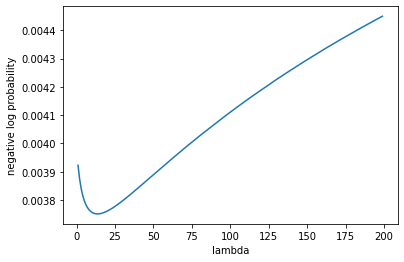

best lambda: 179
best cross validation negative log probability: 0.0037506440559696356
test accuracy: 0.8636363636363636
test negative log probability: [0.00267707 0.00134076 0.00635545 0.0013166  0.00221969 0.00637598
 0.00129451 0.00143353 0.00100381 0.00157435 0.00510038 0.0003621
 0.00431111 0.00953215 0.00268648 0.00212306 0.00201572 0.00137274
 0.00229872 0.00276157 0.00400462 0.00299793 0.00181501 0.00202114
 0.00647893 0.00407796 0.00080966 0.00186134 0.0044416  0.00561111
 0.00352058 0.00824209 0.00122607 0.00531395 0.00162045 0.00119995
 0.00363623 0.00077524 0.00686738 0.00041761 0.00081948 0.0056996
 0.00160486 0.00281722 0.00155195 0.00350874 0.00340693 0.00463824
 0.00129385 0.00129957 0.00736757 0.00041893 0.00607438 0.00435338
 0.00868924 0.00455802 0.00090062 0.00433411 0.00301555 0.00754039
 0.00561391 0.00244627 0.00127668 0.0008465  0.00272904 0.00148979
 0.0035959  0.00164924 0.00194404 0.01366804 0.00058176 0.01383334
 0.00143807 0.00426673 0.00105419 0.00371766 0

In [11]:
# load data
train_inputs, train_labels, test_inputs, test_labels = load_logistic_regression_data()

# rescale inputs in the [-1,1] range
train_inputs = (train_inputs - 8)/8
test_inputs = (test_inputs - 8)/8

# add 1 at the end of each data point
train_inputs = np.concatenate((train_inputs,np.ones((train_inputs.shape[0],1))),1)
test_inputs = np.concatenate((test_inputs,np.ones((test_inputs.shape[0],1))),1)

# rename the classes 5,6 to 0,1
train_labels = train_labels.astype(int) - 5
test_labels = test_labels.astype(int) - 5

# lambda values to be evaluated by cross validation
hyperparams = range(1,200)
k_folds = 10
best_lambda, best_neg_log_prob, neg_log_probabilities = cross_validation_logistic_regression(k_folds,hyperparams,train_inputs,train_labels)

# plot results
plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams)
print('best lambda: ' + str (best_lambda))
print('best cross validation negative log probability: ' + str(best_neg_log_prob))

# train and evaluate with best lambda
weights = train_logistic_regression(train_inputs,train_labels,best_lambda)
neg_log_prob, accuracy = eval_logistic_regression(test_inputs, weights, test_labels)
print('test accuracy: ' + str(accuracy))
print('test negative log probability: ' + str(neg_log_prob))



logistic regression is a parametric approach as it
considers a linear functional form for the labels.
K-Nearest Neighbors (KNN) is a non-parametric method
Logistic regression learns a linear classifier, while 
k-nearest neighbors can learn non-linear boundaries as well and it is a very good nonlinear seperator. KNN is highly dependent on distance between samples, as the number of dimensions increase in dataset, the distance are going to be less representative. 
Accuracy of KNN=0.76.
Accuracy of Logistic regression= 0.87.
For this particular data set, logistic regression  outperforms K-NN which can be due the high dimensionality of data. The higher accuracy of logisitc regression illustrates that the linear seperator performs better than the non linear seperator.

In [12]:
class Perceptron:
  def __init__(self, train_x, train_y, test_x, test_y, lr=0.0001):
    self.w = initialize_weights(train_x.shape[1]) # 65x1
    self.error_history = []
    self.lr = lr

    self.train_x = train_x
    self.train_y = train_y
    self.test_x  = test_x
    self.test_y  = test_y

  def feedForward(self, x):
    z = x.dot(self.w)
    return sigmoid(z)

  def backProp(self, X, y, h):
    gradient = ((h-y).dot(X))
    self.w = self.w - self.lr*gradient
  
  def train(self):
    X, y = self.train_x, self.train_y

    while True:
      h = self.feedForward(X)
      self.backProp(X, y, h)
      error , _ = eval_logistic_regression(X, self.w, y)
      error = error.mean()
      self.error_history.append(error)

      print(error)
      if len(self.error_history)>3 and self.error_history[-3] == self.error_history[-2] == self.error_history[-1]:
         break;

perceptron = Perceptron(train_inputs, train_labels, test_inputs, test_labels)
perceptron.train()

Streaming output truncated to the last 5000 lines.
0.0003215290385347953
0.00032152903853478786
0.0003215290385347803
0.00032152903853477295
0.00032152903853476536
0.0003215290385347579
0.00032152903853475045
0.0003215290385347429
0.0003215290385347356
0.0003215290385347281
0.0003215290385347206
0.0003215290385347133
0.00032152903853470573
0.00032152903853469847
0.0003215290385346908
0.0003215290385346836
0.0003215290385346761
0.0003215290385346687
0.00032152903853466144
0.000321529038534654
0.0003215290385346467
0.0003215290385346393
0.0003215290385346319
0.0003215290385346246
0.0003215290385346172
0.0003215290385346099
0.0003215290385346026
0.00032152903853459525
0.0003215290385345879
0.0003215290385345806
0.00032152903853457324
0.00032152903853456587
0.00032152903853455855
0.0003215290385345514
0.0003215290385345441
0.00032152903853453687
0.0003215290385345295
0.0003215290385345222
0.00032152903853451497
0.00032152903853450776
0.0003215290385345005
0.00032152903853449334
0.000321529

yes It's linearly seperable. because perceptron algorithm converges.